In [1]:
import os, sys
import numpy as np
import numpy.random as rd
import pandas as pd
import scipy as sp
from scipy import stats as st

from sklearn.covariance import GraphLasso
from sklearn.preprocessing import StandardScaler

import pystan

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import font_manager
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
%matplotlib inline

# OS判別 ======================
flag_win32 = False
try:
    os.uname()
except AttributeError:
    flag_win32 = True
    
# Mac用フォント設定
if not flag_win32:
    font_path = '/Library/Fonts/Osaka.ttf'
    font_prop = font_manager.FontProperties(fname=font_path)
    matplotlib.rcParams['font.family'] = font_prop.get_name()
    plt.rcParams['font.family'] = 'Osaka'

img_path = "img/"
if not os.path.exists(img_path):
    os.mkdir(img_path)

In [2]:
def test_data_gen(disp=False, random_state = 71, size=10000):
    """
    disp: True:グラフを描画, False:描画しない
    random_state: 乱数生成のシード
    size: 生成するデータ数
    """
    
    # 多変量正規分布の乱数生成用の共分散行列
    cov = [[   1, .29, .49, .10, .30,  0],
           [ .29,   1,-.49, .49, .40,  0],
           [ .49,-.49,   1,   0,   0,  0],
           [ .10, .49,   0,   1,   0,  0],
           [ .30, .40,   0,   0,   1,  0],
           [   0,   0,   0,   0,   0,  1]]
    M = len(cov) 
    m = np.zeros(M)
    
    # 6つの変数を作成
    X = st.multivariate_normal.rvs(mean=m, cov=cov, size=size, random_state=random_state)
    
    # x4とx6に相関を持たせる
    X[:,3] += 0.6*X[:,5]
    
    # x5とx6に相関を持たせる
    X[:,4] += 0.6*X[:,5]
    
    M = X.shape[1]
    label = ["x{}".format(i+1) for i in range(M)]

    # 標準化
    sc = StandardScaler()
    sc.fit(X)
    X = sc.transform(X)
    
    # 生成したデータの可視化
    if disp:
        plt.figure(figsize=(3*3, M//3*2))
        for i in range(M):
            plt.subplot(M//3,3,i+1)
            plt.hist(X[:,i],bins=20)
            plt.title(label[i])
        plt.savefig(img_path+"hist.png", dpi=128)
        plt.tight_layout()
        plt.show()
            
        sns.pairplot(pd.DataFrame(X, columns=label))
        plt.savefig(img_path+"X_pair_plot.png", dpi=128)
        plt.show()
        
        plt.figure(figsize=(11,10))
        ax = plt.subplot(2,2,1)
        sns.heatmap(pd.DataFrame(cov), annot=np.asanyarray(cov), fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
        plt.title("original Covariance matrix")
        
        ax = plt.subplot(2,2,2)
        cov_inv = sp.linalg.inv(cov)
        sns.heatmap(pd.DataFrame(cov_inv), annot=np.asanyarray(cov_inv), fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
        plt.title("original Precision matrix")

        ax = plt.subplot(2,2,3)
        X_cov = pd.DataFrame(X).cov()
        sns.heatmap(X_cov, annot=X_cov, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
        plt.title("estimated Covariance matrix")
        
        ax = plt.subplot(2,2,4)
        X_cov_inv = sp.linalg.inv(pd.DataFrame(X).cov())
        sns.heatmap(X_cov_inv, annot=X_cov_inv, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
        plt.title("estimated Precision matrix")
        plt.savefig(img_path+"cov_prec_org_est.png", dpi=128)
        
        rho = np.empty_like(X_cov_inv)
        for i in range(M):
            for j in range(M):
                rho[i, j] = -X_cov_inv[i, j]/np.sqrt(X_cov_inv[i, i]*X_cov_inv[j, j])
        plt.figure(figsize=(11,4))
        
        ax = plt.subplot(121)
        X_cor = pd.DataFrame(X).corr()
        sns.heatmap(pd.DataFrame(X_cor), annot=X_cor, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
        plt.title("Correlation Coefficiant of X")
        
        ax = plt.subplot(122)
        sns.heatmap(pd.DataFrame(rho), annot=rho, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
        plt.title("Partial correlation Coefficiant with simple estimated cov")
        
        
        plt.savefig(img_path+"partial_corr_est.png", dpi=128)
        plt.show()
        
    return X, label

### 偏相関係数
精度行列から算出できる。直接相関をあらわす。  
$$
\hat{\rho}_{ij} = {-\lambda_{ij} \over \sqrt{\lambda_{i}\lambda_{jj}}}
$$

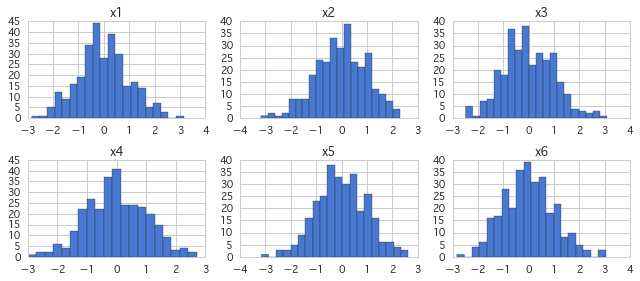

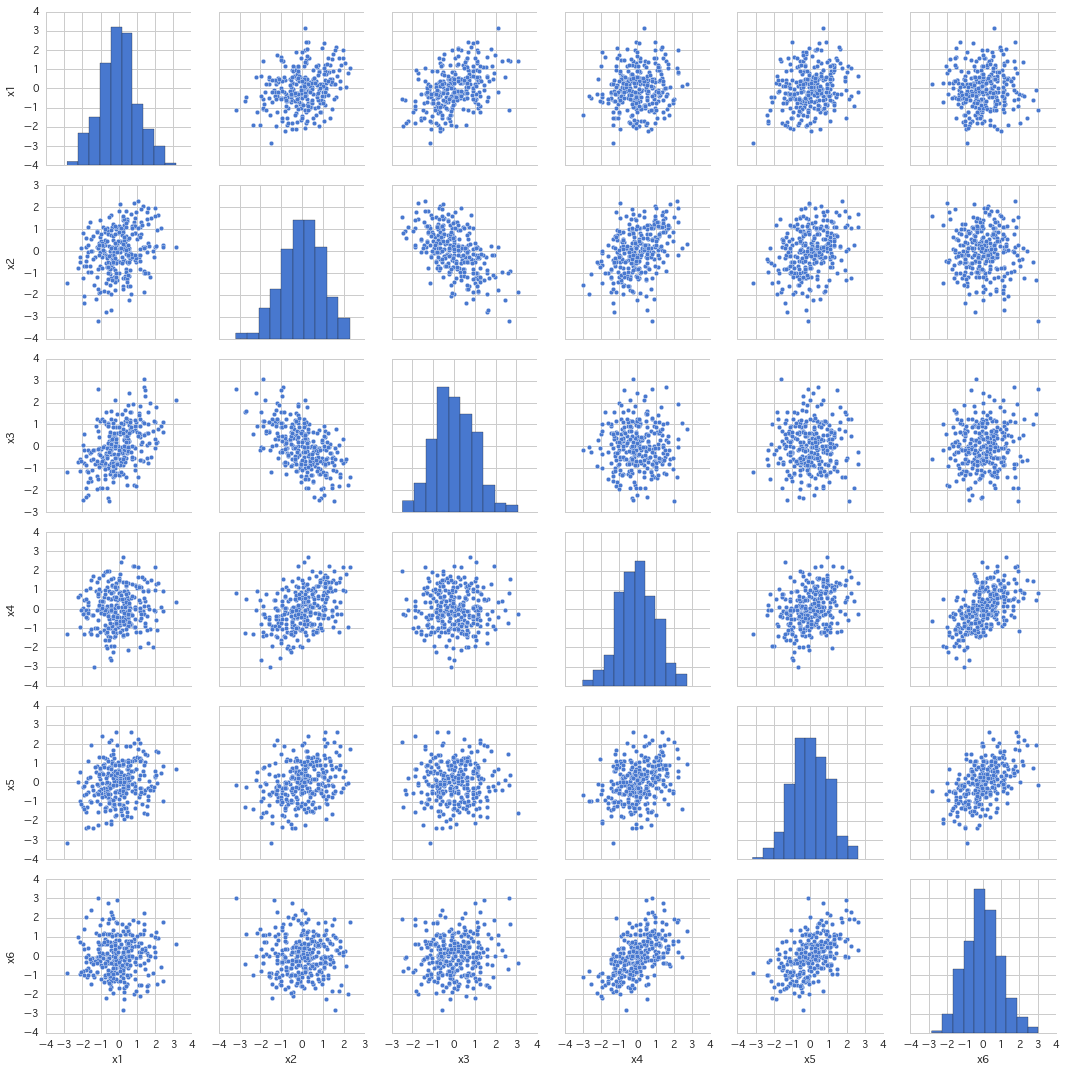

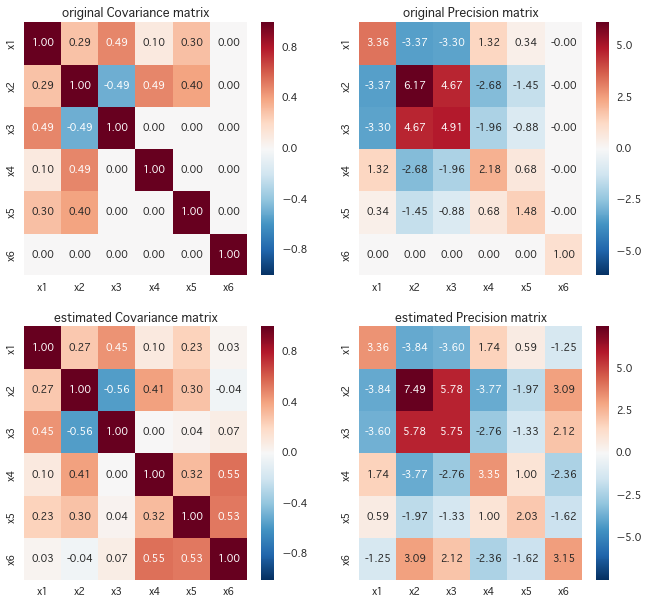

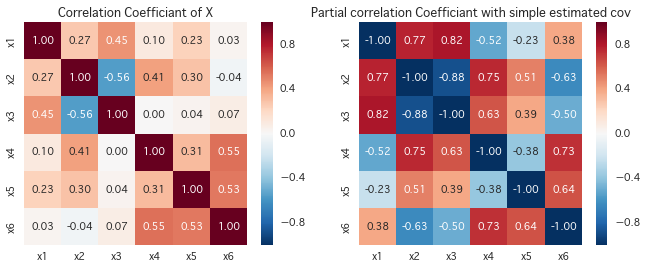

In [3]:
# テストデータ生成
X, label = test_data_gen(disp=True, size=300)
P = X.shape[1]

# Scikit-Learnの利用

In [4]:
# parametars
alpha = 0.2 # L１正則化パラメーター

In [5]:
# Scikit LearnのGraphical Lassoを使ってブロック降下法で分散共分散行列、精度行列を求める
model = GraphLasso(alpha=alpha,
                     max_iter=100,                     
                     verbose=True,
                     assume_centered = True)

model.fit(X)
cov_ = model.covariance_ # 分散共分散行列
prec_ = model.precision_ # 精度行列

[graph_lasso] Iteration   0, cost  2.76e+01, dual gap 5.709e-01
[graph_lasso] Iteration   1, cost  2.75e+01, dual gap 4.333e-05


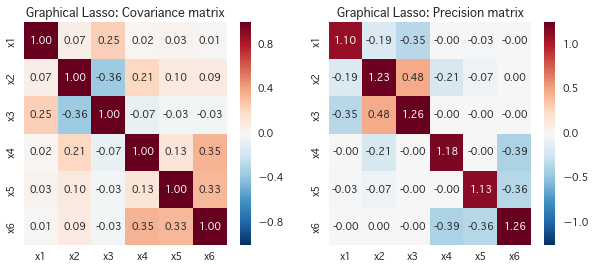

In [6]:
# Scikit LearnのGraphical Lassoの結果表示
plt.figure(figsize=(10,4))
ax = plt.subplot(121)
sns.heatmap(cov_, annot=cov_, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
plt.title("Graphical Lasso: Covariance matrix")

ax = plt.subplot(122)
sns.heatmap(prec_, annot=prec_, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
plt.title("Graphical Lasso: Precision matrix")
plt.savefig(img_path+"glasso_cov_prec.png", dpi=128)
plt.show()

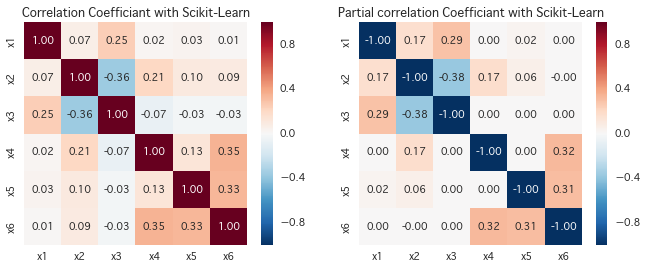

In [7]:
# 相関行列の算出
cor = np.empty_like(cov_)
for i in range(P):
    for j in range(P):
        cor[i, j] = cov_[i, j]/np.sqrt(cov_[i, i]*cov_[j, j])
        
# 偏相関行列の算出
rho = np.empty_like(prec_)
for i in range(P):
    for j in range(P):
        rho[i, j] = -prec_[i, j]/np.sqrt(prec_[i, i]*prec_[j, j])
        
plt.figure(figsize=(11,4))
ax = plt.subplot(122)
sns.heatmap(pd.DataFrame(rho), annot=rho, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
plt.title("Partial correlation Coefficiant with Scikit-Learn")
#plt.savefig(img_path+"partial_corr_sklearn.png", dpi=128)

ax = plt.subplot(121)
sns.heatmap(pd.DataFrame(cor), annot=cor, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
plt.title("Correlation Coefficiant with Scikit-Learn")
plt.savefig(img_path+"corr_pcorr_sklearn.png", dpi=128)
plt.show()

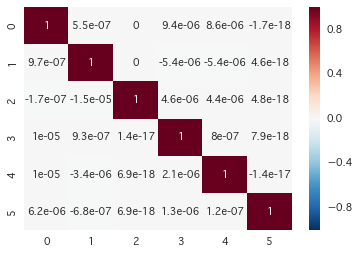

In [8]:
# ちゃんと単位行列になっているか確認してみる。
sns.heatmap(np.dot(cov_, prec_), annot=np.dot(cov_, prec_))
plt.savefig(img_path+"glasso_inv.png", dpi=128)

# Stanの利用

In [9]:
%time sm = pystan.StanModel(file='glasso.stan')
print('Compile finished.')

CPU times: user 974 ms, sys: 51.1 ms, total: 1.02 s
Wall time: 36.2 s
Compile finished.


In [10]:
n_sample = 1000  # 1 chainあたりのサンプル数
n_warm   = 1000  # warm upに使う数
n_chain  = 4     # chain数
stan_data = {'N': X.shape[0], 'P': P, 'X': X, 'alpha': alpha}
%time fit = sm.sampling(data=stan_data, chains=n_chain, iter=n_sample+n_warm, warmup=n_warm)
print('Sampling finished.')

CPU times: user 78.4 ms, sys: 62.1 ms, total: 140 ms
Wall time: 1min 21s
Sampling finished.


In [11]:
fit

Inference for Stan model: anon_model_31ac7e216f1b5eccff16f1394bd9827e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Lambda[0,0]    1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   4000    nan
Lambda[1,0]  -0.31  9.1e-4   0.05   -0.4  -0.34  -0.31  -0.28  -0.21   2775    1.0
Lambda[2,0]  -0.42  8.0e-4   0.04   -0.5  -0.45  -0.42  -0.39  -0.33   2822    1.0
Lambda[3,0]   0.04  1.1e-3   0.05  -0.07 4.2e-4   0.04   0.07   0.14   2672    1.0
Lambda[4,0]  -0.11  9.4e-4   0.05  -0.21  -0.15  -0.11  -0.08-8.7e-3   3145    1.0
Lambda[5,0]   0.02  9.8e-4   0.05  -0.08  -0.02   0.02   0.06   0.13   3059    1.0
Lambda[0,1]  -0.31  9.1e-4   0.05   -0.4  -0.34  -0.31  -0.28  -0.21   2775    1.0
Lambda[1,1]    1.0 1.5e-189.0e-17    1.0    1.0    1.0    1.0    1.0   3757    nan
Lambda[2,1]   0.47  6.6e-4   0.04   0.39   0.44   0.47    0.5   

In [12]:
# 推定したパラメーターの取り出し
Lambda = fit.extract()["Lambda"]
Sigma  = fit.extract()["Sigma"]

In [13]:
# EAP推定量の算出
EAP_Sigma  = np.mean(Sigma, axis=0)
EAP_Lambda = np.mean(Lambda, axis=0)

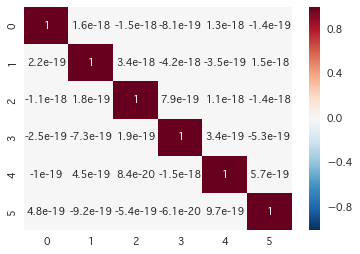

In [14]:
# ちゃんと単位行列になっているか確認してみる。
est_inv = np.empty_like(Sigma[0])
for i in range(len(Sigma)):
    est_inv += np.dot(Sigma[i], Lambda[i])
est_inv = est_inv/len(Sigma)
sns.heatmap(est_inv, annot=est_inv)
plt.savefig(img_path+"glasso_stan_inv.png", dpi=128)

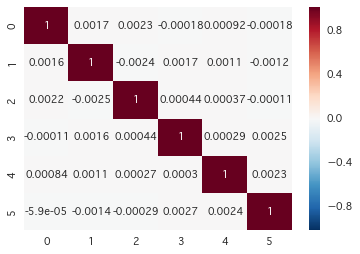

In [15]:
# ちゃんと単位行列になっているか確認してみる。
sns.heatmap(np.dot(EAP_Sigma, EAP_Lambda), annot=np.dot(EAP_Sigma, EAP_Lambda))
plt.savefig(img_path+"glasso_stan_inv.png", dpi=128)
# -> EAP同士だとちょっと誤差がある

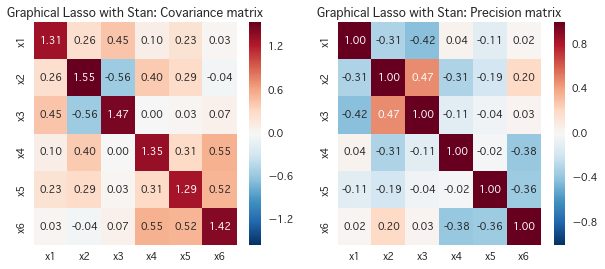

In [16]:
# EAP推定量の可視化
plt.figure(figsize=(10,4))
ax = plt.subplot(121)
sns.heatmap(pd.DataFrame(EAP_Sigma), annot=EAP_Sigma, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
plt.title("Graphical Lasso with Stan: Covariance matrix")

ax = plt.subplot(122)
sns.heatmap(pd.DataFrame(EAP_Lambda), annot=EAP_Lambda, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
plt.title("Graphical Lasso with Stan: Precision matrix")
plt.savefig(img_path+"glasso_stan_cov_prec.png", dpi=128)
plt.show()

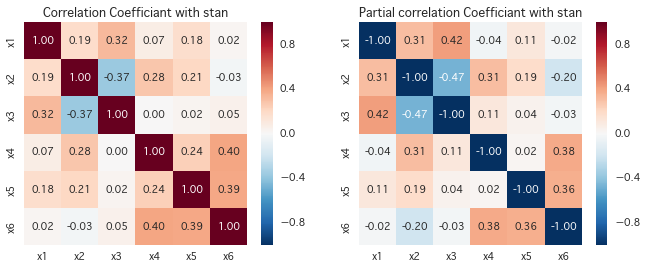

In [17]:
# 相関行列の算出
EAP_cor = np.empty_like(EAP_Sigma)
for i in range(P):
    for j in range(P):
        EAP_cor[i, j] = EAP_Sigma[i, j]/np.sqrt(EAP_Sigma[i, i]*EAP_Sigma[j, j])
        
# 偏相関行列の算出
EAP_rho = np.empty_like(EAP_Lambda)
for i in range(P):
    for j in range(P):
        EAP_rho[i, j] = -EAP_Lambda[i, j]/np.sqrt(EAP_Lambda[i, i]*EAP_Lambda[j, j])
        
plt.figure(figsize=(11,4))
ax = plt.subplot(122)
sns.heatmap(pd.DataFrame(EAP_rho), annot=EAP_rho, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
plt.title("Partial correlation Coefficiant with stan")
#plt.savefig(img_path+"partial_corr_sklearn.png", dpi=128)

ax = plt.subplot(121)
sns.heatmap(pd.DataFrame(EAP_cor), annot=EAP_cor, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
plt.title("Correlation Coefficiant with stan")
plt.savefig(img_path+"corr_pcorr_stan.png", dpi=128)
plt.show()

0, 0: 0, 1: 0, 2: 0, 3: 

/Users/matsuken/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


0, 4: 0, 5: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 2, 2: 2, 3: 2, 4: 2, 5: 3, 3: 3, 4: 3, 5: 4, 4: 4, 5: 5, 5: 

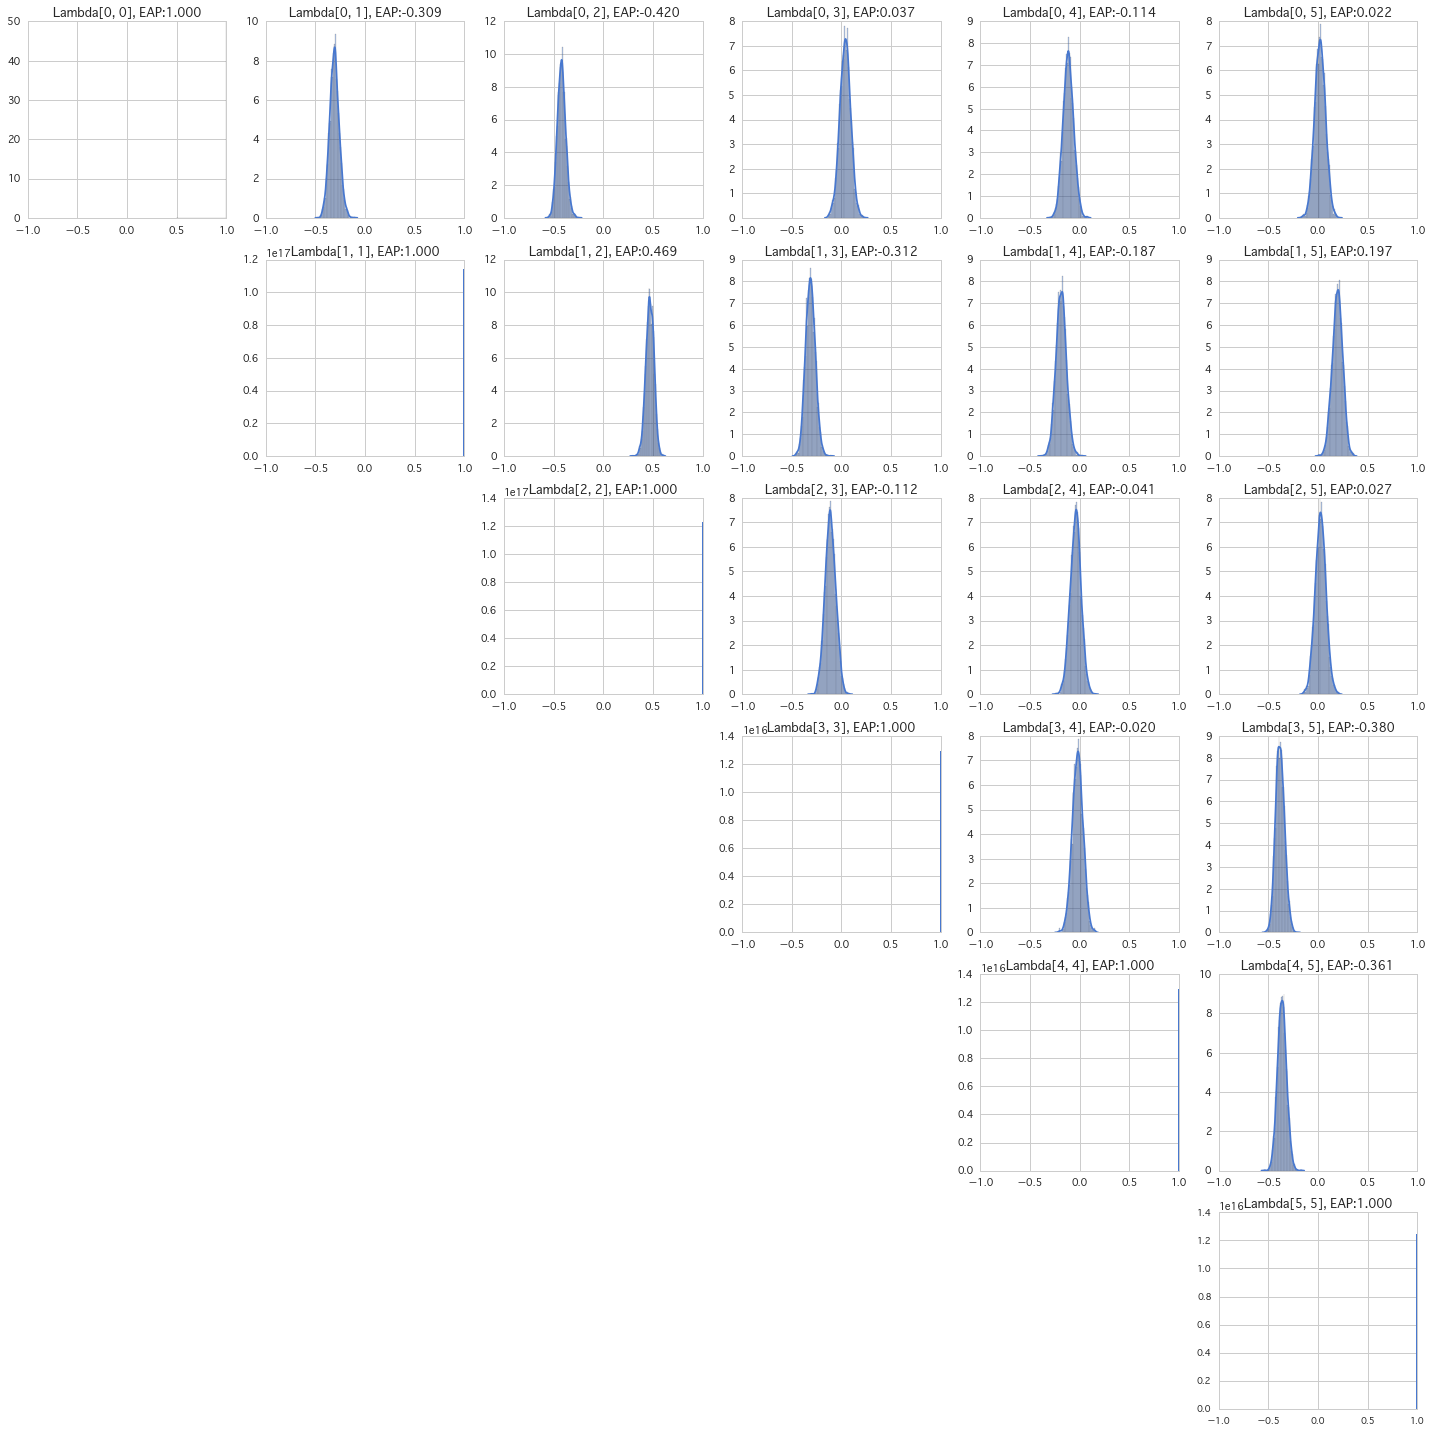

In [18]:
# 各値の位置がわかるように　xlimを固定してヒストグラムを描画
plt.figure(figsize=(20, 20))
for i in range(P):
    for j in range(P):
        if j >= i:
            sys.stdout.write("{}, {}: ".format(i, j))
            plt.subplot(P, P, i*6+j+1)
            eap = np.mean(Lambda[:, i, j])
            sns.distplot(Lambda[:, i, j])
            plt.xlim(-1, 1)
            plt.title("Lambda[{0}, {1}], EAP:{2:.3f}".format(i, j, eap))
            
plt.tick_params(labelsize=9)
plt.tight_layout()
plt.savefig(img_path+"grid_dist_plot1.png", dpi=128)

0, 0: 0, 1: 

/Users/matsuken/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


0, 2: 0, 3: 0, 4: 0, 5: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 2, 2: 2, 3: 2, 4: 2, 5: 3, 3: 3, 4: 3, 5: 4, 4: 4, 5: 5, 5: 

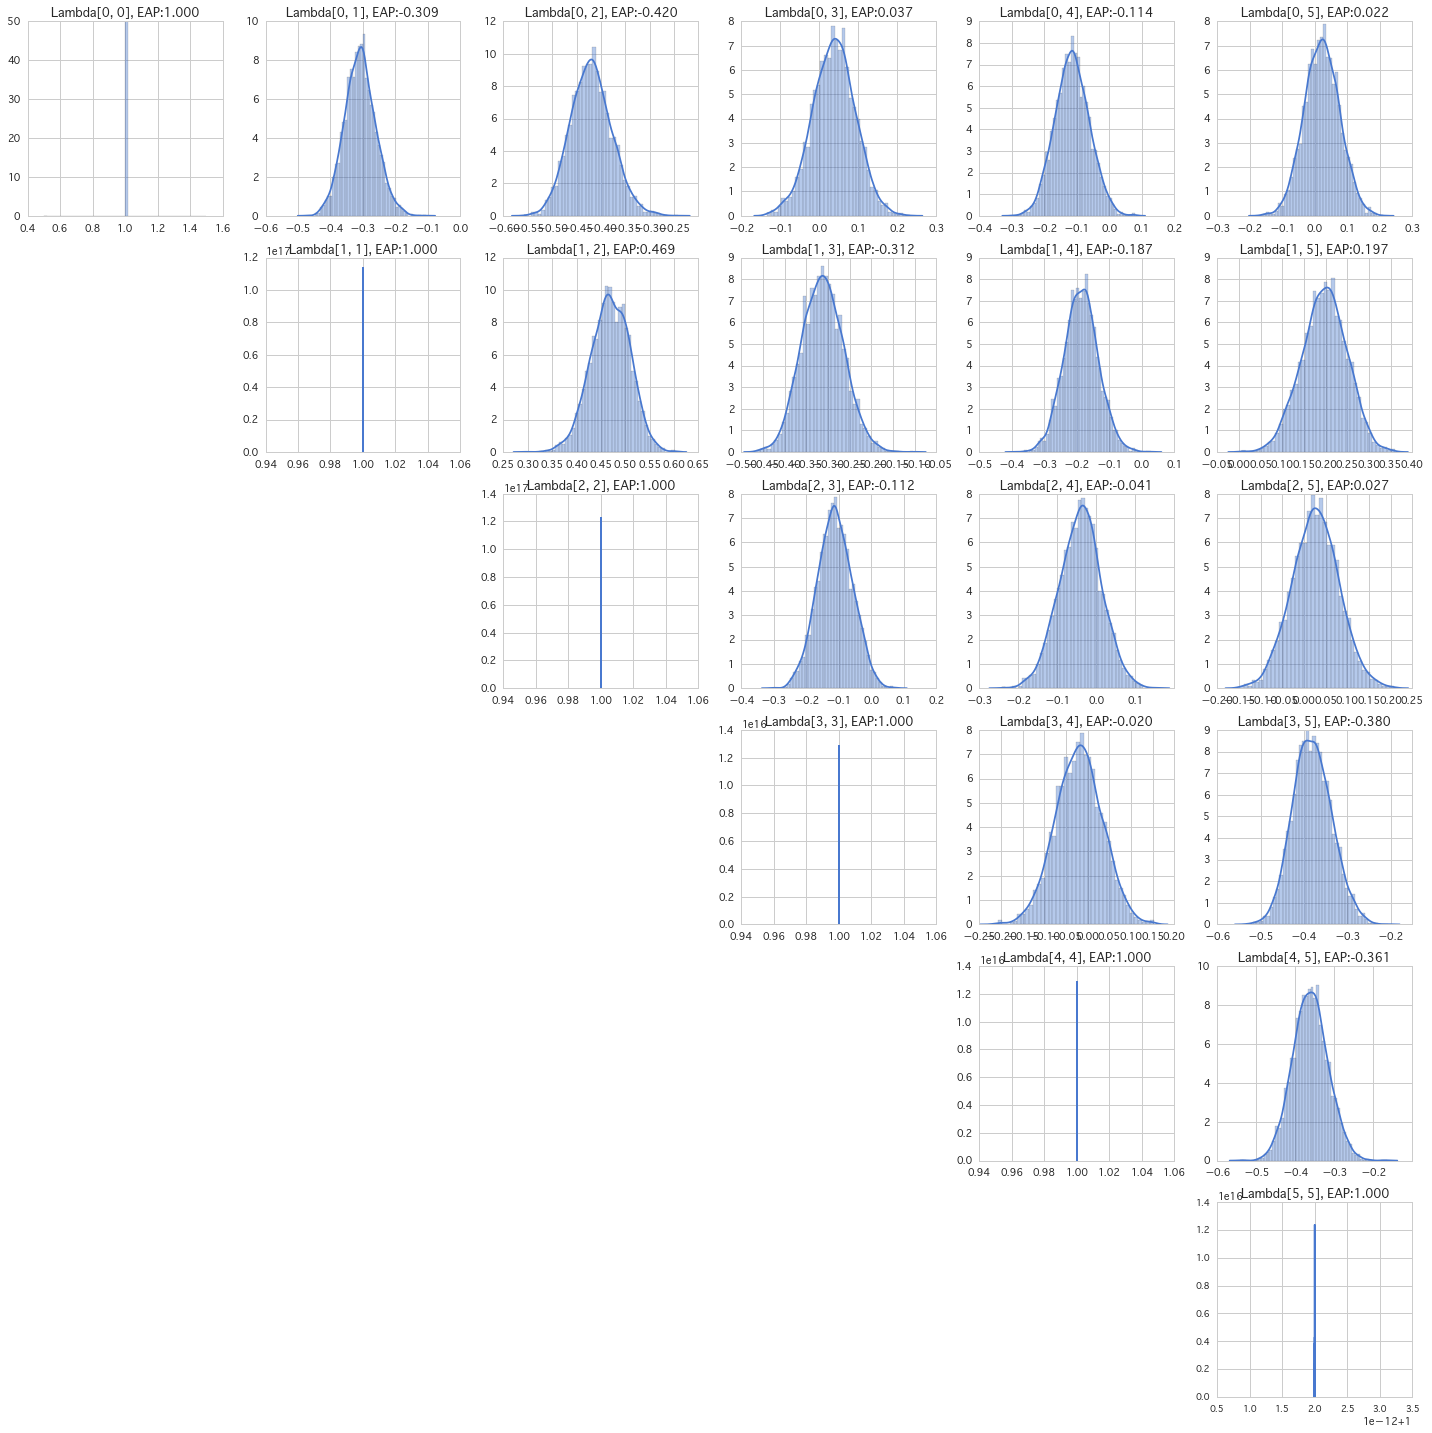

In [ ]:
# 拡大プロットしてヒストグラムを描画
plt.figure(figsize=(20, 20))
for i in range(P):
    for j in range(P):
        if j >= i:
            sys.stdout.write("{}, {}: ".format(i, j))
            plt.subplot(P, P, i*6+j+1)
            eap = np.mean(Lambda[:, i, j])
            sns.distplot(Lambda[:, i, j])
            #plt.xlim(-3, 3)
            plt.title("Lambda[{0}, {1}], EAP:{2:.3f}".format(i, j, eap))
            
plt.tick_params(labelsize=9)
plt.tight_layout()
plt.savefig(img_path+"grid_dist_plot2.png", dpi=128)

In [ ]:
# Trace plotの描画
n_graph = P*(P+1)/2
cnt = 1
plt.figure(figsize=(10,40))
for i in range(P):
    for j in range(P):
        if j >= i:
            sys.stdout.write("{}, {}: ".format(i, j))
            plt.subplot(n_graph, 1, cnt)
            cnt += 1
            chains = np.array([Lambda[n*n_sample:(n+1)*n_sample, i, j] for n in range(n_chain)])
            for k in range(n_chain):
                plt.plot(chains[k], lw=1, alpha=0.7)
            plt.title("Trace plot: [{}, {}]".format(i, j))
plt.tight_layout()
plt.savefig(img_path+"trace_plot.png", dpi=128)

0, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 2, 2: 2, 3: 2, 4: 2, 5: 3, 3: 3, 4: 3, 5: 4, 4: 4, 5: 5, 5: 

## 参考
偏相関係数(Partial Correration Coefficient)　　  
http://www.ae.keio.ac.jp/lab/soc/takeuchi/lectures/5_Parcor.pdf
    